In [2]:
#importing all the needed libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [3]:
#scaling, normalization
from sklearn.preprocessing import StandardScaler, MinMaxScaler

#kmeans, dbscan, hierarchical (sklearn)
from sklearn.cluster import KMeans, DBSCAN, AgglomerativeClustering
#evaluation
from sklearn.metrics import silhouette_score
#import dataset
from sklearn.datasets import load_iris

#distance matrix (dbscan elbow, hierarchical)
from scipy.spatial.distance import pdist, squareform

# hierarchical (scipy)
from scipy.cluster.hierarchy import linkage, dendrogram, fcluster

# --- DBSCAN (with distance-based eps tuning) ---
from sklearn.neighbors import NearestNeighbors

import random



In [ ]:
df = pd.read_csv("./dataset/DM1_game_dataset_cleaned.csv")

# Select numeric columns and drop missing values
df_num = df.select_dtypes(include=['float64', 'int64'])
numeric_cols = [col for col in df_num.columns if df_num[col].nunique() > 2]  # exclude binary columns

df_num = df_num[numeric_cols]

# exclude BGGId
df_num = df_num.drop(columns=['BGGId'], errors='ignore')


X = df_num.values

print(f"Data shape: {X.shape}, Features: {df_num.columns.tolist()}")

# Standardize the data
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

Data shape: (21925, 18), Features: ['YearPublished', 'GameWeight', 'NumWish', 'MfgPlaytime', 'MfgAgeRec', 'NumUserRatings', 'NumAlternates', 'NumExpansions', 'NumImplementations', 'Rank:strategygames', 'Rank:abstracts', 'Rank:familygames', 'Rank:thematic', 'Rank:cgs', 'Rank:wargames', 'Rank:partygames', 'Rank:childrensgames', 'Players']


## 1. K-Means

In [5]:
kmeans = KMeans(n_clusters=20, n_init=10, max_iter=100, random_state=94)
kmeans.fit(X_scaled)

KMeans(max_iter=100, n_clusters=20, n_init=10, random_state=94)

In [6]:
# labels
labels = kmeans.labels_
labels

array([ 4,  1,  4, ...,  4, 11,  5], dtype=int32)

In [7]:
# centroids
centroids = kmeans.cluster_centers_
centroids

array([[ 1.16685532e-01,  6.84900376e-01,  3.93983168e+00,
        -1.16516336e-02,  4.61295679e-01,  3.14203871e+00,
         4.91680702e-01,  6.26324958e-01,  5.64218044e-01,
        -3.74563618e-02, -1.89119680e-01, -2.14984780e-01,
        -7.22474788e-02, -9.45865507e-02, -3.68226008e-01,
        -1.15928794e-01, -1.76327688e-01, -4.47337284e-02],
       [ 1.07245945e-01, -6.68515766e-01, -1.88535283e-01,
        -1.02968425e-01, -6.93298414e-01, -1.54799635e-01,
        -3.74736963e-02, -1.33464848e-01, -1.67645681e-01,
        -2.86002588e-01, -1.70212064e-01, -2.37227163e-01,
        -2.05088851e-01, -1.02088158e-01, -3.65900374e-01,
        -1.28070693e-01, -1.35441479e-01, -2.29174241e-02],
       [ 8.91477880e-02,  3.14139994e-01, -4.82447047e-02,
        -9.51563691e-03,  4.80025934e-01, -5.56841728e-02,
        -5.63782180e-02,  7.35830598e-02, -1.12654938e-02,
         4.83107808e-01, -1.89607801e-01,  1.57797890e-01,
         4.88550833e+00, -7.94440480e-02, -7.50238927e

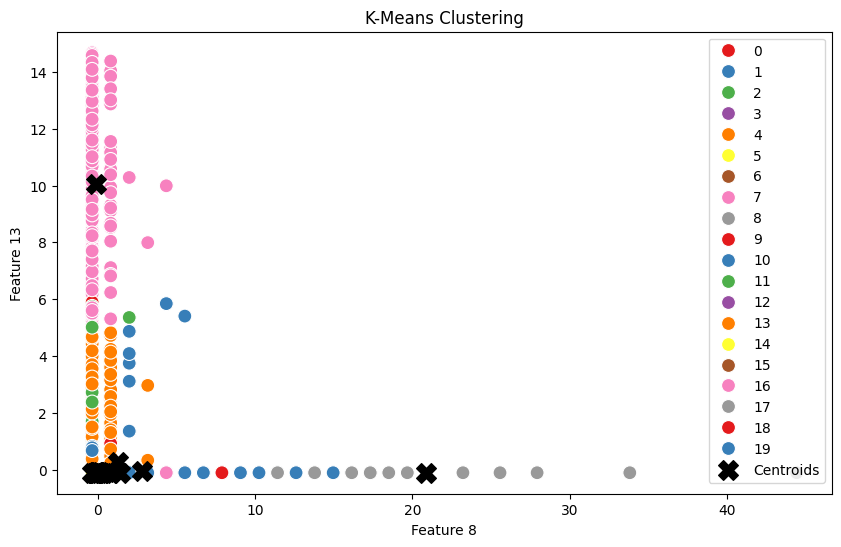

In [8]:
# plotting the clusters
plt.figure(figsize=(10, 6))

sns.scatterplot(x=X_scaled[:, 8], y=X_scaled[:, 13], hue=labels, palette='Set1', s=100)
plt.scatter(centroids[:, 8], centroids[:, 13], c='black', s=200, marker='X', label='Centroids')
plt.title('K-Means Clustering')
plt.xlabel('Feature 8')
plt.ylabel('Feature 13')
plt.legend()
plt.show()

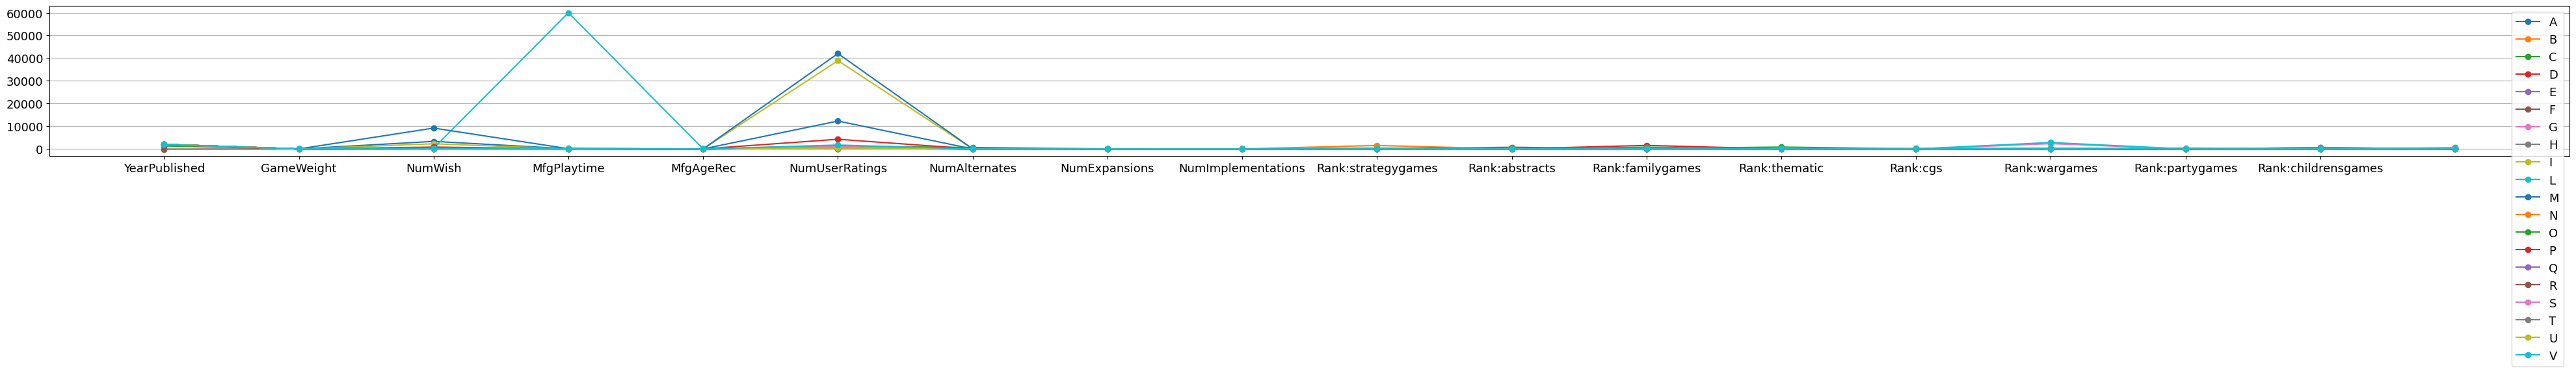

In [9]:
plt.figure(figsize=(50, 3))

centers = scaler.inverse_transform(centroids)

clust_name = ['A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V']

for i in range(len(centers)):
    plt.plot(centers[i], marker='o', label=clust_name[i])

plt.xticks(range(0,len(df_num.columns) - 1), df_num.columns[:-1], fontsize=13)
plt.yticks(fontsize=13)

plt.legend(fontsize=13, loc='best')
plt.grid(axis='y')

In [10]:
# SSE and silhouette score
sse = kmeans.inertia_
print(f'SSE: {sse:.4f}')

sil_score = silhouette_score(X_scaled, labels)
print(f'Silhouette Score: {sil_score:.4f}')

SSE: 109947.3719
Silhouette Score: 0.3247


In [11]:
%%time
sse_list = []

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100, random_state = 42)
    kmeans.fit(X_scaled)
    sse_list.append(kmeans.inertia_)

CPU times: total: 2min 35s
Wall time: 24.8 s


In [12]:
%%time
sil_list = []
dist = squareform(pdist(X_scaled)) # using a precomputed distance matrix

for k in range(2, 51):
    kmeans = KMeans(n_clusters=k, n_init=10, max_iter=100)
    kmeans.fit(X_scaled)
    sil_list.append(silhouette_score(dist, kmeans.labels_, metric='precomputed'))

CPU times: total: 5min 33s
Wall time: 3min 6s


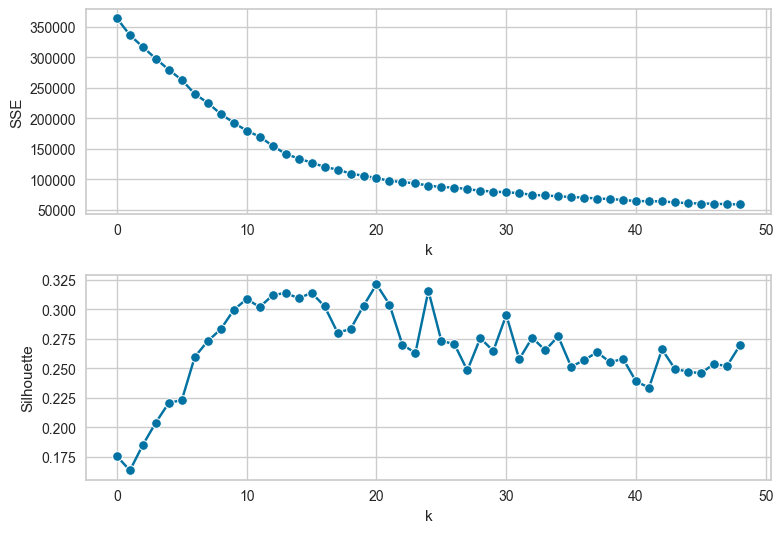

In [29]:
fig, axs = plt.subplots(2)

sns.lineplot(x=range(len(sse_list)), y=sse_list, marker='o', ax=axs[0])
axs[0].set(xlabel='k', ylabel='SSE')

sns.lineplot(x=range(len(sil_list)), y=sil_list, marker='o', ax=axs[1])
axs[1].set(xlabel='k', ylabel='Silhouette')

plt.tight_layout() # Adjust the padding between and around subplots
plt.show()

In [30]:
# finding couple of features with high silhouette score
from itertools import combinations
feature_indices = range(X_scaled.shape[1])
best_score = -1
best_pair = None

for pair in combinations(feature_indices, 2):
    X_pair = X_scaled[:, pair]
    kmeans = KMeans(n_clusters=20, n_init=10, max_iter=100, random_state=94)
    kmeans.fit(X_pair)
    score = silhouette_score(X_pair, kmeans.labels_)
    if score > best_score:
        best_score = score
        best_pair = pair
print(f'Best feature pair: {best_pair} with Silhouette Score: {best_score:.4f}')

Best feature pair: (8, 13) with Silhouette Score: 0.9908


## SSE Statistical Evaluation

In [ ]:
random.seed(42)
N = 500
sse_stats = []

for _ in range(N):
    Xi = np.zeros(shape=X_scaled.shape)

    for cidx in range(Xi.shape[1]):
        col = X_scaled[:, cidx]
        min, max, nor = np.min(col), np.max(col), len(col)
        Xi[:, cidx] = np.random.uniform(min, max, (1, nor))

    kmeans = KMeans(n_clusters=3, n_init=10, max_iter=100, random_state=94)
    kmeans.fit(Xi)
    sse_stats.append(kmeans.inertia_)

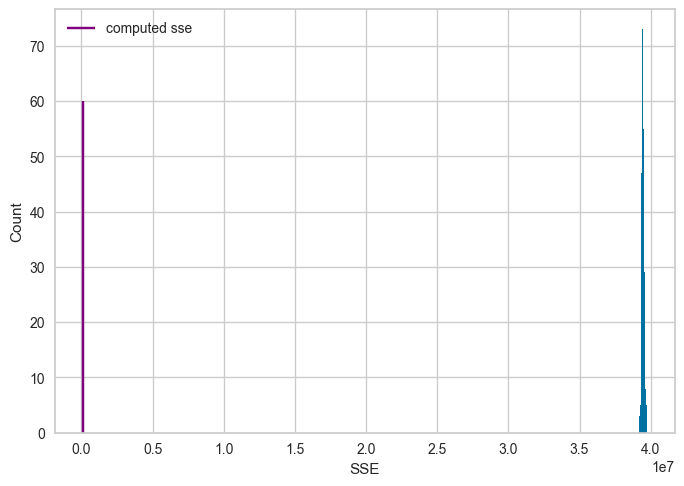

In [35]:
plt.hist(sse_stats, bins='auto')
plt.vlines(x = sse, ymin = 0, ymax = 60, colors = 'purple', label = 'computed sse')
plt.xlabel('SSE')
plt.ylabel('Count')
plt.legend()
plt.show()

## Correlation statistical evaluation

In [ ]:
N = 500
corr_stats = []

for _ in range(N):
    Xi = np.zeros(shape=X_scaled.shape)

    for cidx in range(Xi.shape[1]):
        col = X_scaled[:, cidx]
        min, max, nor = np.min(col), np.max(col), len(col)
        Xi[:, cidx] = np.random.uniform(min, max, (1, nor))

    kmeans = KMeans(n_clusters=3, n_init=10, max_iter=100, random_state=94)
    kmeans.fit(Xi)
    # compute correlation matrix (distance matrix - 0-1 matrix)
    # distance matrix
    dist_matrix = squareform(pdist(Xi))
    # cluster belonging matrix (1 if same cluster, 0 otherwise)
    cluster_matrix = np.equal.outer(kmeans.labels_, kmeans.labels_).astype(int)
    corr = np.corrcoef(dist_matrix.flatten(), cluster_matrix.flatten())[0, 1]
    corr_stats.append(corr)

In [ ]:
plt.hist(corr_stats, bins='auto')
plt.vlines(x = 0, ymin = 0, ymax = 60, colors = 'purple', label = 'computed correlation = 0')
plt.xlabel('Correlation Coefficient')
plt.ylabel('Count')
plt.legend()
plt.show()